In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import pandahouse
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline

plt.style.use('seaborn-whitegrid')

sns.set(font_scale = 1.25,
        style = 'whitegrid',
        rc = {'figure.figsize': (14, 3)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

---

In [3]:
# Выгрузим данные всех юзеров, которые пришли в приложение в течении последнего 21 дня.
query = '''select * 
from 
    (select 
        user_id, 
        toDate(time) as time_of_action,
        source
    from simulator_20220920.feed_actions) as l
inner join 
    (select 
        user_id,
        toDate(min(time)) as first_visit
    from simulator_20220920.feed_actions
    group by user_id) as r
using user_id
where first_visit >= today() - 21'''

In [4]:
df = pandahouse.read_clickhouse(query, connection = connection)

In [5]:
df.head(3)

,user_id,time_of_action,source,first_visit
0,63830,2022-10-10,ads,2022-10-02
1,151702,2022-10-10,organic,2022-09-21
2,156639,2022-10-10,organic,2022-09-25


In [6]:
df.shape

(6057389, 4)

In [7]:
# Создадим колонку с разницей во времени между первым визитом и действием в приложении
df['day_after'] = (df.time_of_action - df.first_visit).dt.days

In [8]:
df.head(3)

,user_id,time_of_action,source,first_visit,day_after
0,63830,2022-10-10,ads,2022-10-02,8
1,151702,2022-10-10,organic,2022-09-21,19
2,156639,2022-10-10,organic,2022-09-25,15


In [9]:
# Разделим юзеров по источнику трафика
df_ads = df.query('source == "ads"')[['user_id', 'first_visit', 'day_after']]
df_organic = df.query('source == "organic"')[['user_id', 'first_visit', 'day_after']]

In [10]:
def cohort_analysis(df):
    """
    Данная функция принимает датафрейм с 3 колонками (user_id, first_visit, day_after)
        и возвращает датафрейм с результатами когортного анализа,
        а также выводит на печать тепловую карту для когортного анализа.
    """
    
    # Группируем по когорте и периодом времени между первым визитом и действием, агрегируем по уникальным id
    df_ads_grouped = df.groupby(['first_visit', 'day_after'], as_index = False).agg({'user_id': pd.Series.nunique}) \
        .sort_values(['first_visit', 'day_after'])
    
    df_ads_grouped['first_visit'] = df_ads_grouped['first_visit'].dt.date
    
    # Делаем сводную таблицу
    cohort_count = df_ads_grouped.pivot_table(index = 'first_visit', columns = 'day_after', values = 'user_id')
    
    # Переводим retention в проценты
    cohort_size = cohort_count.iloc[:, 0]
    retention = cohort_count.divide(cohort_size, axis = 0)
    
    # Визуализируем
    plt.figure(figsize = (22, 11))
    plt.title('Cohort Analysis - Retention Rate')
    sns.heatmap(data = retention, 
                annot = True, 
                fmt = '.0%', 
                vmin = 0.0,
                vmax = 0.5,
                cmap = "YlGnBu")
    
    plt.show()
    
    return(retention)

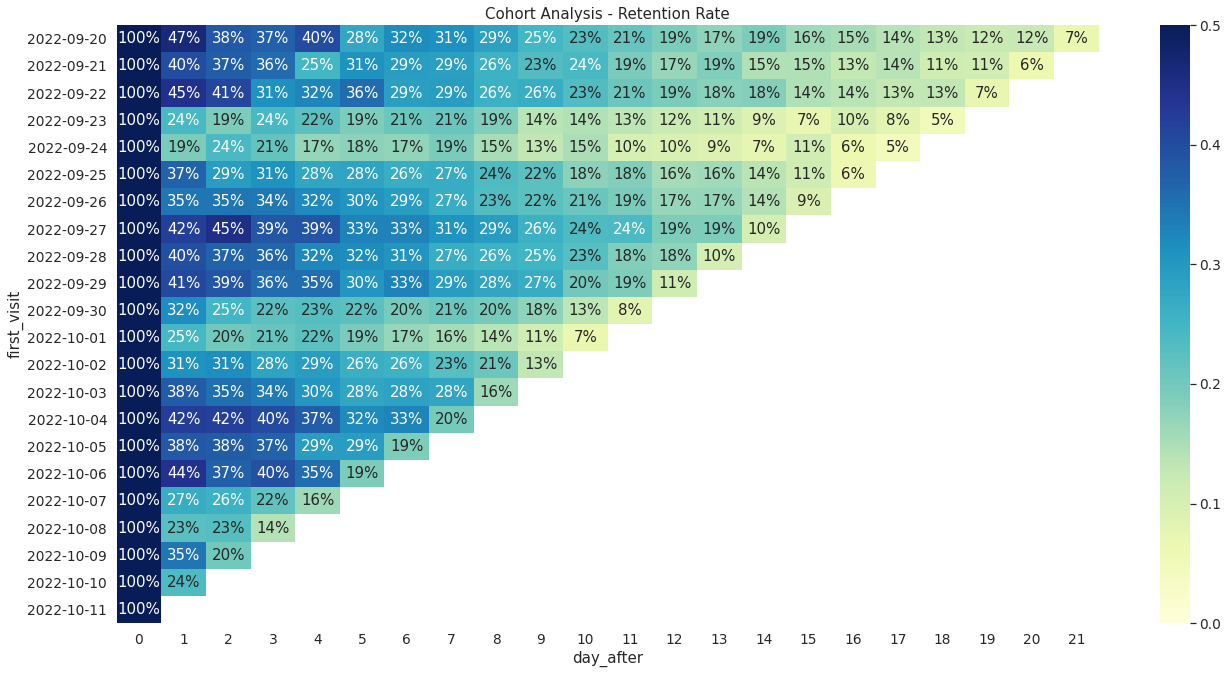

In [11]:
# Применим функцию для юзеров пришедших черех рекламный трафик
ret_ads = cohort_analysis(df_ads)

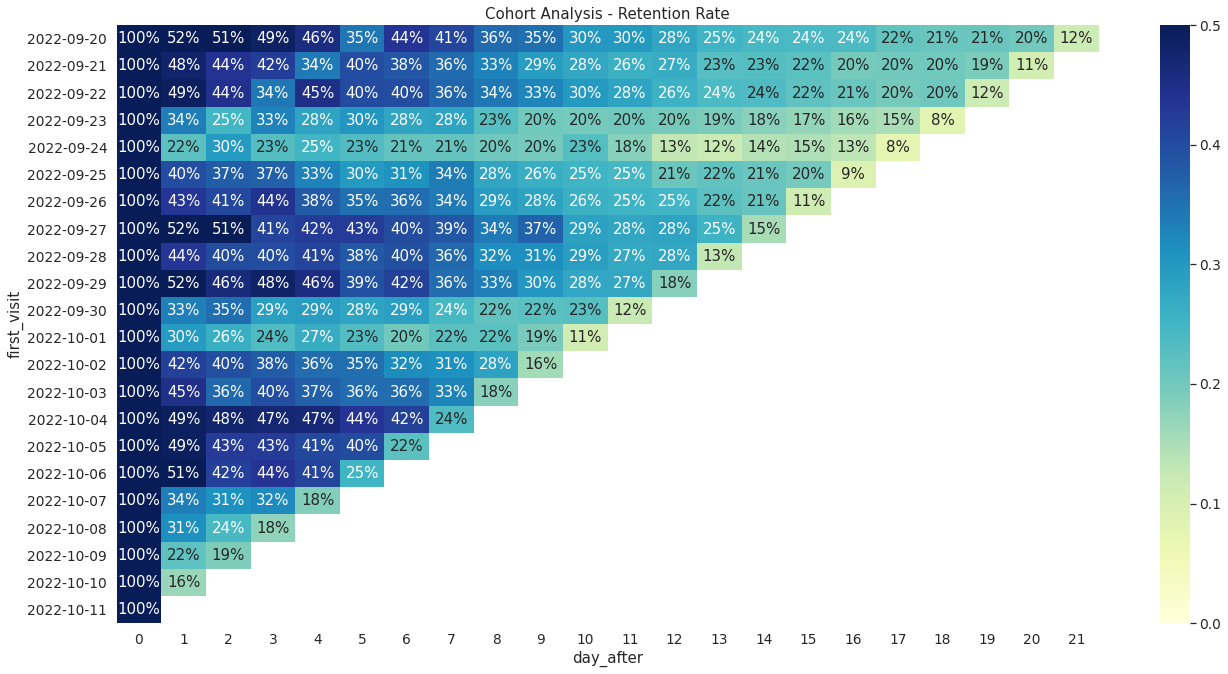

In [12]:
# Применим функцию для юзеров пришедших черех органический трафик
ret_organic = cohort_analysis(df_organic)

Если сравнивать хитмапы для рекламного и органического трафика то становится видно, что ритеншн стабильно выше у органического трафика.
Для наглядности сравним разницу в абсолютных значениях:

In [13]:
difference = ret_organic - ret_ads

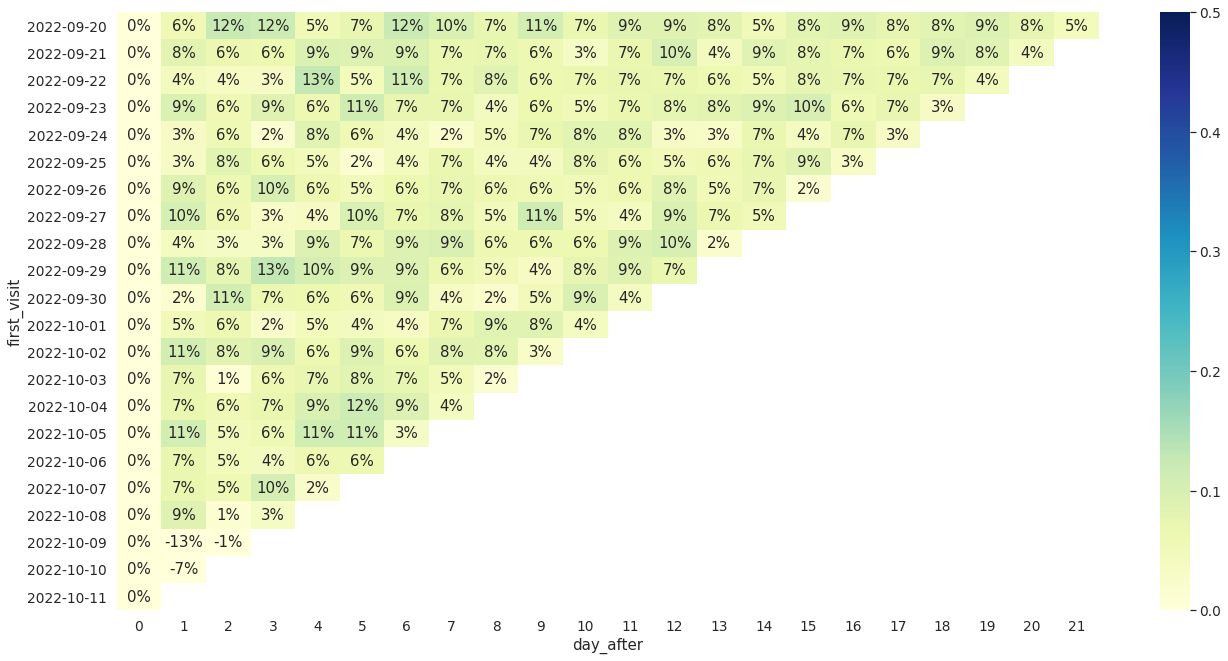

In [14]:
plt.figure(figsize = (22, 11))
plt.title('')
sns.heatmap(data = difference, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

In [15]:
# Усредненные различия по когортам
difference.apply(np.mean, axis = 1) * 100

first_visit
2022-09-20    7.842632
2022-09-21    6.868641
2022-09-22    6.333853
2022-09-23    6.755616
2022-09-24    4.764493
2022-09-25    5.162291
2022-09-26    5.894722
2022-09-27    6.183343
2022-09-28    6.033540
2022-09-29    7.570631
2022-09-30    5.386391
2022-10-01    4.835017
2022-10-02    6.839945
2022-10-03    4.773770
2022-10-04    6.686275
2022-10-05    6.645681
2022-10-06    4.606819
2022-10-07    5.063102
2022-10-08    3.362275
2022-10-09   -4.637356
2022-10-10   -3.617613
2022-10-11    0.000000
dtype: float64

In [16]:
# Усредненные различия по дням после первого визита
difference.apply(np.mean, axis = 0) * 100

day_after
0     0.000000
1     5.332277
2     5.582140
3     6.411410
4     7.130229
5     7.376892
6     7.383843
7     6.556204
8     5.625602
9     6.356768
10    6.246243
11    6.867732
12    7.626756
13    5.394190
14    6.805631
15    6.774758
16    6.435771
17    6.181442
18    6.939910
19    7.233674
20    5.928315
21    4.647523
dtype: float64

In [17]:
# Усредненная разница по всем когортам
np.mean(difference.apply(np.mean, axis = 1) * 100)

4.697912229572396

In [18]:
# Усредненная разница по всем дням
np.mean(difference.apply(np.mean, axis = 0) * 100)

6.128968622071738

Различия в абсолютных значениях в ретеншене рекламного и органического трафика очевидны, но не понятно, являются ли такие различия статичстически значимыми. 

Сравним данные для каждой когорты тестом Мана-Уитни


In [19]:
p_values = []

for i in range(ret_organic.shape[0]):
    p_values.append(stats.mannwhitneyu(ret_organic.iloc[i, :].dropna(), ret_ads.iloc[i, :].dropna(), alternative='greater')[1].round(2))

results = pd.DataFrame({'cohort': ret_organic.index, 'p value': p_values})

print(results)

        cohort  p value
0   2022-09-20     0.02
1   2022-09-21     0.03
2   2022-09-22     0.04
3   2022-09-23     0.01
4   2022-09-24     0.01
5   2022-09-25     0.06
6   2022-09-26     0.05
7   2022-09-27     0.08
8   2022-09-28     0.03
9   2022-09-29     0.06
10  2022-09-30     0.03
11  2022-10-01     0.03
12  2022-10-02     0.02
13  2022-10-03     0.06
14  2022-10-04     0.05
15  2022-10-05     0.05
16  2022-10-06     0.21
17  2022-10-07     0.17
18  2022-10-08     0.28
19  2022-10-09     0.75
20  2022-10-10     0.79
21  2022-10-11     1.00


Финальный вопрос: отличается ли характер использования приложения у этих групп пользователей?

Ответ: да, у большинства когорт ретеншн статистически значимо отличается на уровне доверия 0.9.